<a href="https://colab.research.google.com/github/Anuradha-Ranathunga/Inventory-Prediction-Program/blob/main/Inventory_Prediction_Program.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install flask flask-ngrok tensorflow pandas numpy scikit-learn joblib

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

train_df = pd.read_csv("train.csv")
train_df['date'] = pd.to_datetime(train_df['date'], errors='coerce')

scaler = MinMaxScaler()
train_df['sales_scaled'] = scaler.fit_transform(train_df[['sales']])

import joblib
joblib.dump(scaler, 'scaler.pkl')

train_df.head()

,date,store,item,sales,sales_scaled
0,2013-01-01,1,1,13,0.056277
1,2013-01-02,1,1,11,0.047619
2,2013-01-03,1,1,14,0.060606
3,2013-01-04,1,1,13,0.056277
4,2013-01-05,1,1,10,0.043290


In [ ]:
SEQ_LENGTH = 30

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i: i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

X_train, y_train = [], []
for (store, item), group in train_df.groupby(['store', 'item']):
    sales_seq = group['sales_scaled'].values
    X_seq, y_seq = create_sequences(sales_seq, SEQ_LENGTH)
    X_train.append(X_seq)
    y_train.append(y_seq)

X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)
X_train = np.expand_dims(X_train, axis=-1)

X_train.shape, y_train.shape

((898000, 30, 1), (898000,))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    BatchNormalization(),
    Dense(25, activation="relu"),
    Dense(1, activation="linear")
])

model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

model.save("inventory_lstm_model.h5")

Epoch 1/10
11225/11225 ━━━━━━━━━━━━━━━━━━━━ 395s 35ms/step - loss: 0.0124 - val_loss: 0.0017
Epoch 2/10
11225/11225 ━━━━━━━━━━━━━━━━━━━━ 434s 34ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 3/10
 6843/11225 ━━━━━━━━━━━━━━━━━━━━ 2:15 31ms/step - loss: 0.0014

In [ ]:
from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model
import joblib

from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model
import joblib
from tensorflow.keras.losses import MeanSquaredError

app = Flask(__name__)

model = load_model("inventory_lstm_model.h5", custom_objects={"mse": MeanSquaredError()})
model.compile(loss='mse', optimizer='adam', metrics=['mean_absolute_error'])
scaler = joblib.load("scaler.pkl")

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    store = data['store']
    item = data['item']
    date = pd.to_datetime(data['date'])

    past_data = train_df[(train_df['store'] == store) & (train_df['item'] == item)].tail(SEQ_LENGTH)

    if len(past_data) < SEQ_LENGTH:
        return jsonify({"error": "Not enough historical data"}), 400

    past_sales = past_data['sales_scaled'].values.reshape(1, SEQ_LENGTH, 1)

    predicted_sales_scaled = model.predict(past_sales)[0][0]
    predicted_sales = scaler.inverse_transform([[predicted_sales_scaled]])[0][0]

    return jsonify({"store": store, "item": item, "date": str(date.date()), "predicted_sales": round(predicted_sales, 2)})

if __name__ == '__main__':
    app.run()

In [ ]:
train_df = pd.read_csv("train.csv")
train_df['date'] = pd.to_datetime(train_df['date'], errors='coerce')

scaler = MinMaxScaler()
train_df['sales_scaled'] = scaler.fit_transform(train_df[['sales']])

actual_sales = train_df['sales_scaled'].values

num_samples = len(actual_sales) - SEQ_LENGTH + 1
actual_sales_reshaped = np.array([actual_sales[i:i + SEQ_LENGTH] for i in range(num_samples)])
actual_sales_reshaped = actual_sales_reshaped.reshape(num_samples, SEQ_LENGTH, 1)

predicted_sales_scaled = model.predict(actual_sales_reshaped)[0][0]
predicted_sales = scaler.inverse_transform([[predicted_sales_scaled]])[0][0]

  698/28531 ━━━━━━━━━━━━━━━━━━━━ 1:18 3ms/step

Exception ignored in: <function _xla_gc_callback at 0x7c0d4a698900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


28531/28531 ━━━━━━━━━━━━━━━━━━━━ 139s 5ms/step


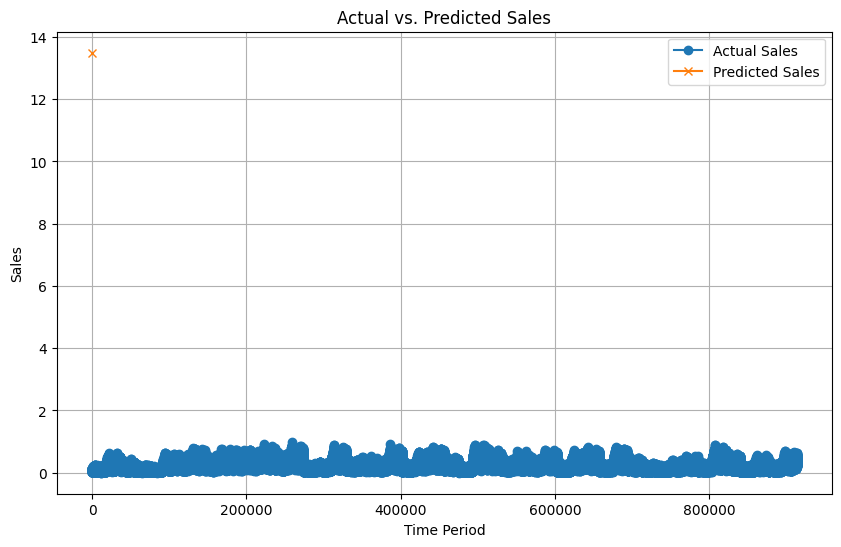

In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(actual_sales, label='Actual Sales', marker='o')
plt.plot(predicted_sales, label='Predicted Sales', marker='x')
plt.xlabel('Time Period')
plt.ylabel('Sales')
plt.title('Actual vs. Predicted Sales')
plt.legend()
plt.grid(True)
plt.show()